title: Debt Collection Handover Exclusions  
author: Jesse Scherwitz  
date: 2023-03-13  
region: EU  
link: https://docs.google.com/presentation/d/16TcMkkXhAuYhgHtQRVOPS6NNPeMd2Y-y32hn8G3_-M8/edit?usp=sharing  
tags: debt_collection, exclusions, collection, dunning, memberships, afc, overdraft, credit  
summary: If we were to lift single handover exclusions or combinations thereof, what would be the monetary impact? Lifting 'never_fau' or 'specific_hrc' exclusions would have the highest impact lead to 2M€ additional handover, _respectively_!

In [2]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
"""
create temp table lel as
with pre as (
    select
        *,
        row_number() over (partition by user_id, reason, amount order by created desc) rn
    from dwh_dunning_handover_exclusions
    -- more than 2y ago can probably not be recovered (this study was done in March 2023)
    where created > '2021-03-01'
)
select
    user_id, collection_id, reason, amount,
    not_activated_prem_fees,
    od_error,
    post_cancellation_prem_fees,
    shufa_deceased,
    offline_pt,
    "less_than_10€",
    under_care,
    specific_hrc,
    never_fau,
    gbr,
    manual_exclusion,
    kyc_reset,
    is_ato,
    pre.created,
    ucm_stg_od_write_off_agg_1.write_off_dt
from pre
    left join cmd_users
        on pre.user_id = cmd_users.id
    left join dbt.ucm_stg_od_write_off_agg_1
        on cmd_users.user_created = ucm_stg_od_write_off_agg_1.user_created
where rn = 1
  and reason != 'TBIL'
  and (
      not_activated_prem_fees or
      od_error or
      post_cancellation_prem_fees or
      shufa_deceased or
      offline_pt or
      -- not negotiable
      --"less_than_10€" or
      under_care or
      specific_hrc or
      never_fau or
      gbr or
      manual_exclusion or
      kyc_reset or
      is_ato
    )
;


create temp table lul as
select lel.*
from lel
left join dwh_dunning_handovers
    on lel.collection_id = dwh_dunning_handovers.collection_id
    and lel.collection_id is not null
left join dwh_dunning_handovers h2
    on lel.user_id = h2.user_id
    and lel.reason = h2.debt_type
    and lel.amount = h2.amount
    and lel.collection_id is null
    and h2.debt_type != 'TBIL'
-- exclude cases that were eventually handed over
where dwh_dunning_handovers.collection_id is null
  and h2.user_id is null
  and (lel.write_off_dt > '2021-03-01'
           -- non OD/TOD
           or write_off_dt is null);
;

select *
from lul
;
"""

'\ncreate temp table lel as\nwith pre as (\n    select\n        *,\n        row_number() over (partition by user_id, reason, amount order by created desc) rn\n    from dwh_dunning_handover_exclusions\n    -- more than 2y ago can probably not be recovered (this study was done in March 2023)\n    where created > \'2021-03-01\'\n)\nselect\n    user_id, collection_id, reason, amount,\n    not_activated_prem_fees,\n    od_error,\n    post_cancellation_prem_fees,\n    shufa_deceased,\n    offline_pt,\n    "less_than_10€",\n    under_care,\n    specific_hrc,\n    never_fau,\n    gbr,\n    manual_exclusion,\n    kyc_reset,\n    is_ato,\n    pre.created,\n    ucm_stg_od_write_off_agg_1.write_off_dt\nfrom pre\n    left join cmd_users\n        on pre.user_id = cmd_users.id\n    left join dbt.ucm_stg_od_write_off_agg_1\n        on cmd_users.user_created = ucm_stg_od_write_off_agg_1.user_created\nwhere rn = 1\n  and reason != \'TBIL\'\n  and (\n      not_activated_prem_fees or\n      od_error or\n 

In [5]:
data = pd.read_csv("/app/fra/live/exclusions_last_2y_20230313.csv")

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
data.is_ato = data.is_ato.fillna(False)

In [7]:
for k in data.columns:
    if set(data[k]).issubset(set([True, False])):
        print(k, data[k].astype(int).sum())

not_activated_prem_fees 16641
od_error 0
post_cancellation_prem_fees 1
shufa_deceased 159
offline_pt 628
less_than_10€ 27078
under_care 58
specific_hrc 24837
never_fau 62605
gbr 0
manual_exclusion 2263
kyc_reset 4426
is_ato 165


In [8]:
data.created.min()

'2021-03-10 07:47:45.000000'

In [6]:
data.columns

Index(['user_id', 'collection_id', 'reason', 'amount',
       'not_activated_prem_fees', 'od_error', 'post_cancellation_prem_fees',
       'shufa_deceased', 'offline_pt', 'less_than_10€', 'under_care',
       'specific_hrc', 'never_fau', 'gbr', 'manual_exclusion', 'kyc_reset',
       'is_ato', 'created'],
      dtype='object')

In [9]:
exclusion_columns = [
    k
    for k in data.columns
    if set(data[k]).issubset(set([True, False]))
    and k != "less_than_10€"
    and k != "od_error"
]

# 'less_than_10€' is not negotiable, od_error does not seem to exist

In [10]:
for k in exclusion_columns:
    print(k, data[data[k] == True].created.max())

not_activated_prem_fees 2023-03-08 02:02:53.602822
post_cancellation_prem_fees 2022-05-08 02:01:11.187554
shufa_deceased 2023-03-08 02:02:53.602822
offline_pt 2023-03-08 02:02:53.602822
under_care 2023-02-08 02:01:58.942942
specific_hrc 2023-03-08 02:02:53.602822
never_fau 2023-03-08 02:02:53.602822
gbr nan
manual_exclusion 2023-03-08 02:02:53.602822
kyc_reset 2023-03-08 02:02:53.602822
is_ato 2023-03-08 02:02:53.602822


In [11]:
from itertools import chain, combinations


def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))

In [12]:
def subsets_cardinality_n(n: int, elements: list):
    # rm empty set
    relevant_subsets = list(powerset(elements))[1:]
    relevant_subsets = [list(k) for k in relevant_subsets]
    subsets_up_to_len_n = [k for k in relevant_subsets if len(k) <= n]

    return subsets_up_to_len_n

In [13]:
def calculate_exclusion_amt_cnt(data: pd.DataFrame, n: int, exclusion_columns: list):
    """Calculate amt and cnt for all exclusion combinations cardinality up to n."""

    subsets_up_to_len_n = subsets_cardinality_n(n, exclusion_columns)

    amt = []
    cnt = []
    excl = []
    n_excl = []

    for subset in subsets_up_to_len_n:
        k = len(subset)

        complement = set(exclusion_columns) - set(subset)

        for i, b in enumerate(subset):
            if i == 0:
                cond = data[b] == True
            else:
                cond = cond & (data[b] == True)

        for b in complement:
            cond = cond & (data[b] == False)

        amt.append(data[cond].amount.sum())
        cnt.append(len(data[cond]))
        excl.append(subset)
        n_excl.append(k)

    result = pd.DataFrame(
        {"exclusions": excl, "cnt": cnt, "amt": amt, "n_excl": n_excl}
    )
    return result

In [14]:
result = calculate_exclusion_amt_cnt(data, 3, exclusion_columns)

In [15]:
def plot(result, cnt_min=0, amt_min=0):
    rows = result.n_excl.max()

    fig, ax = plt.subplots(
        nrows=rows, ncols=2, figsize=(15, 20), sharey="row"
    )  # , sharex='col'

    for n in range(rows):
        result[
            (result["n_excl"] == n + 1)
            & (result["cnt"] > cnt_min)
            & (result["amt"] > amt_min)
        ].plot(x="exclusions", y="cnt", kind="barh", ax=ax[n][0], label="Count")
        result[
            (result["n_excl"] == n + 1)
            & (result["cnt"] > cnt_min)
            & (result["amt"] > amt_min)
        ].plot(
            x="exclusions", y="amt", kind="barh", color="red", ax=ax[n][1], label="€"
        )

    plt.show()

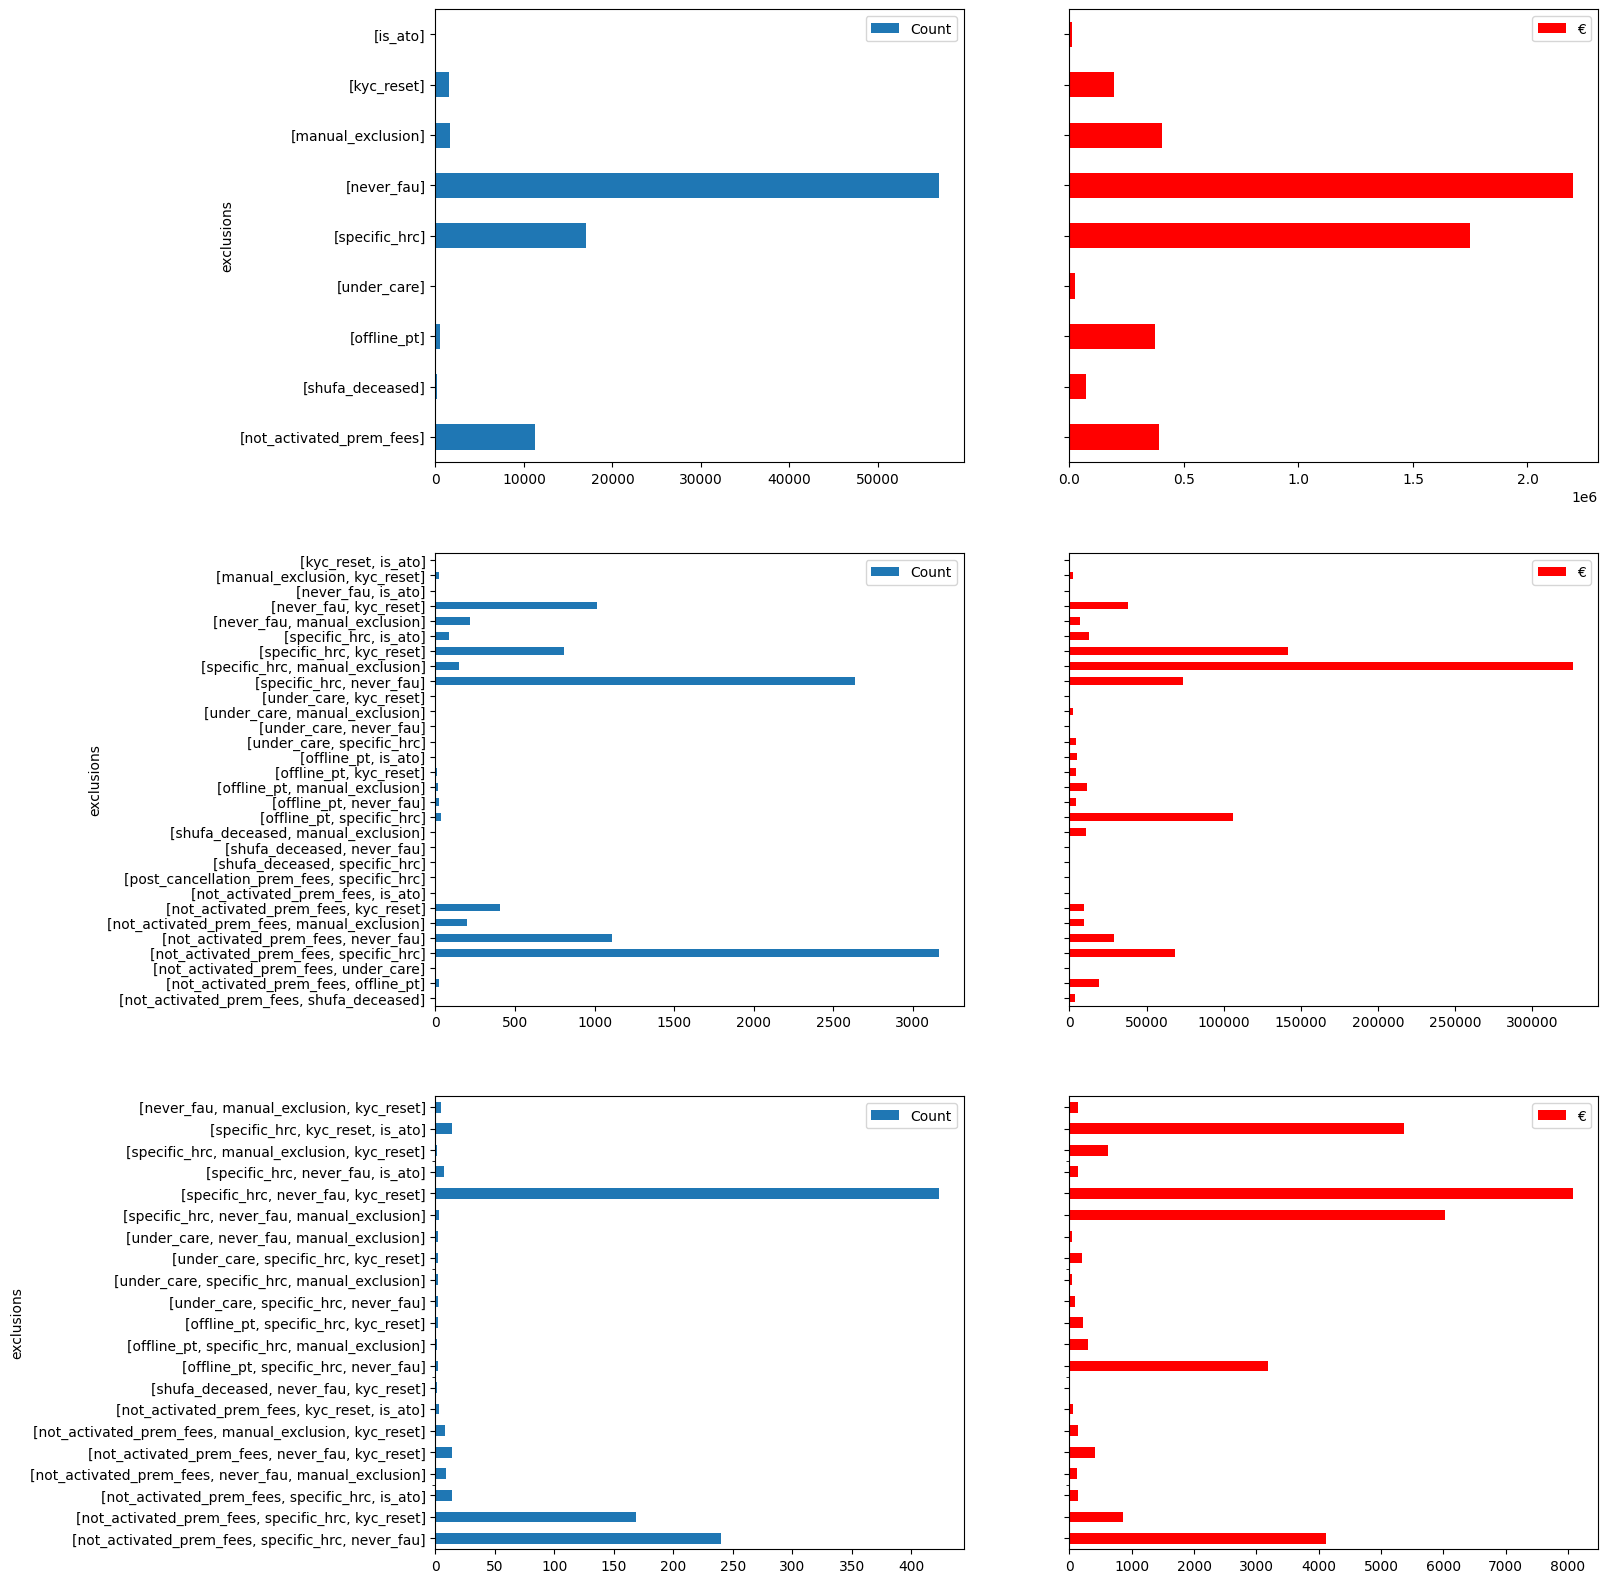

In [16]:
plot(result)

# We decided to focus on the following 4 exclusions

### writeoffs within last 2 years

In [35]:
result_2 = calculate_exclusion_amt_cnt(
    data, 3, ["not_activated_prem_fees", "kyc_reset", "never_fau", "specific_hrc"]
)

In [36]:
result_2

,exclusions,cnt,amt,n_excl
0,[not_activated_prem_fees],11479,422214.45,1
1,[kyc_reset],1525,201148.60,1
2,[never_fau],57109,2209300.10,1
3,[specific_hrc],17311,2198126.13,1
4,"[not_activated_prem_fees, kyc_reset]",414,9300.48,2
5,"[not_activated_prem_fees, never_fau]",1118,28890.47,2
6,"[not_activated_prem_fees, specific_hrc]",3179,68604.65,2
7,"[kyc_reset, never_fau]",1019,38060.42,2
8,"[kyc_reset, specific_hrc]",830,147909.94,2
9,"[never_fau, specific_hrc]",2653,83005.58,2


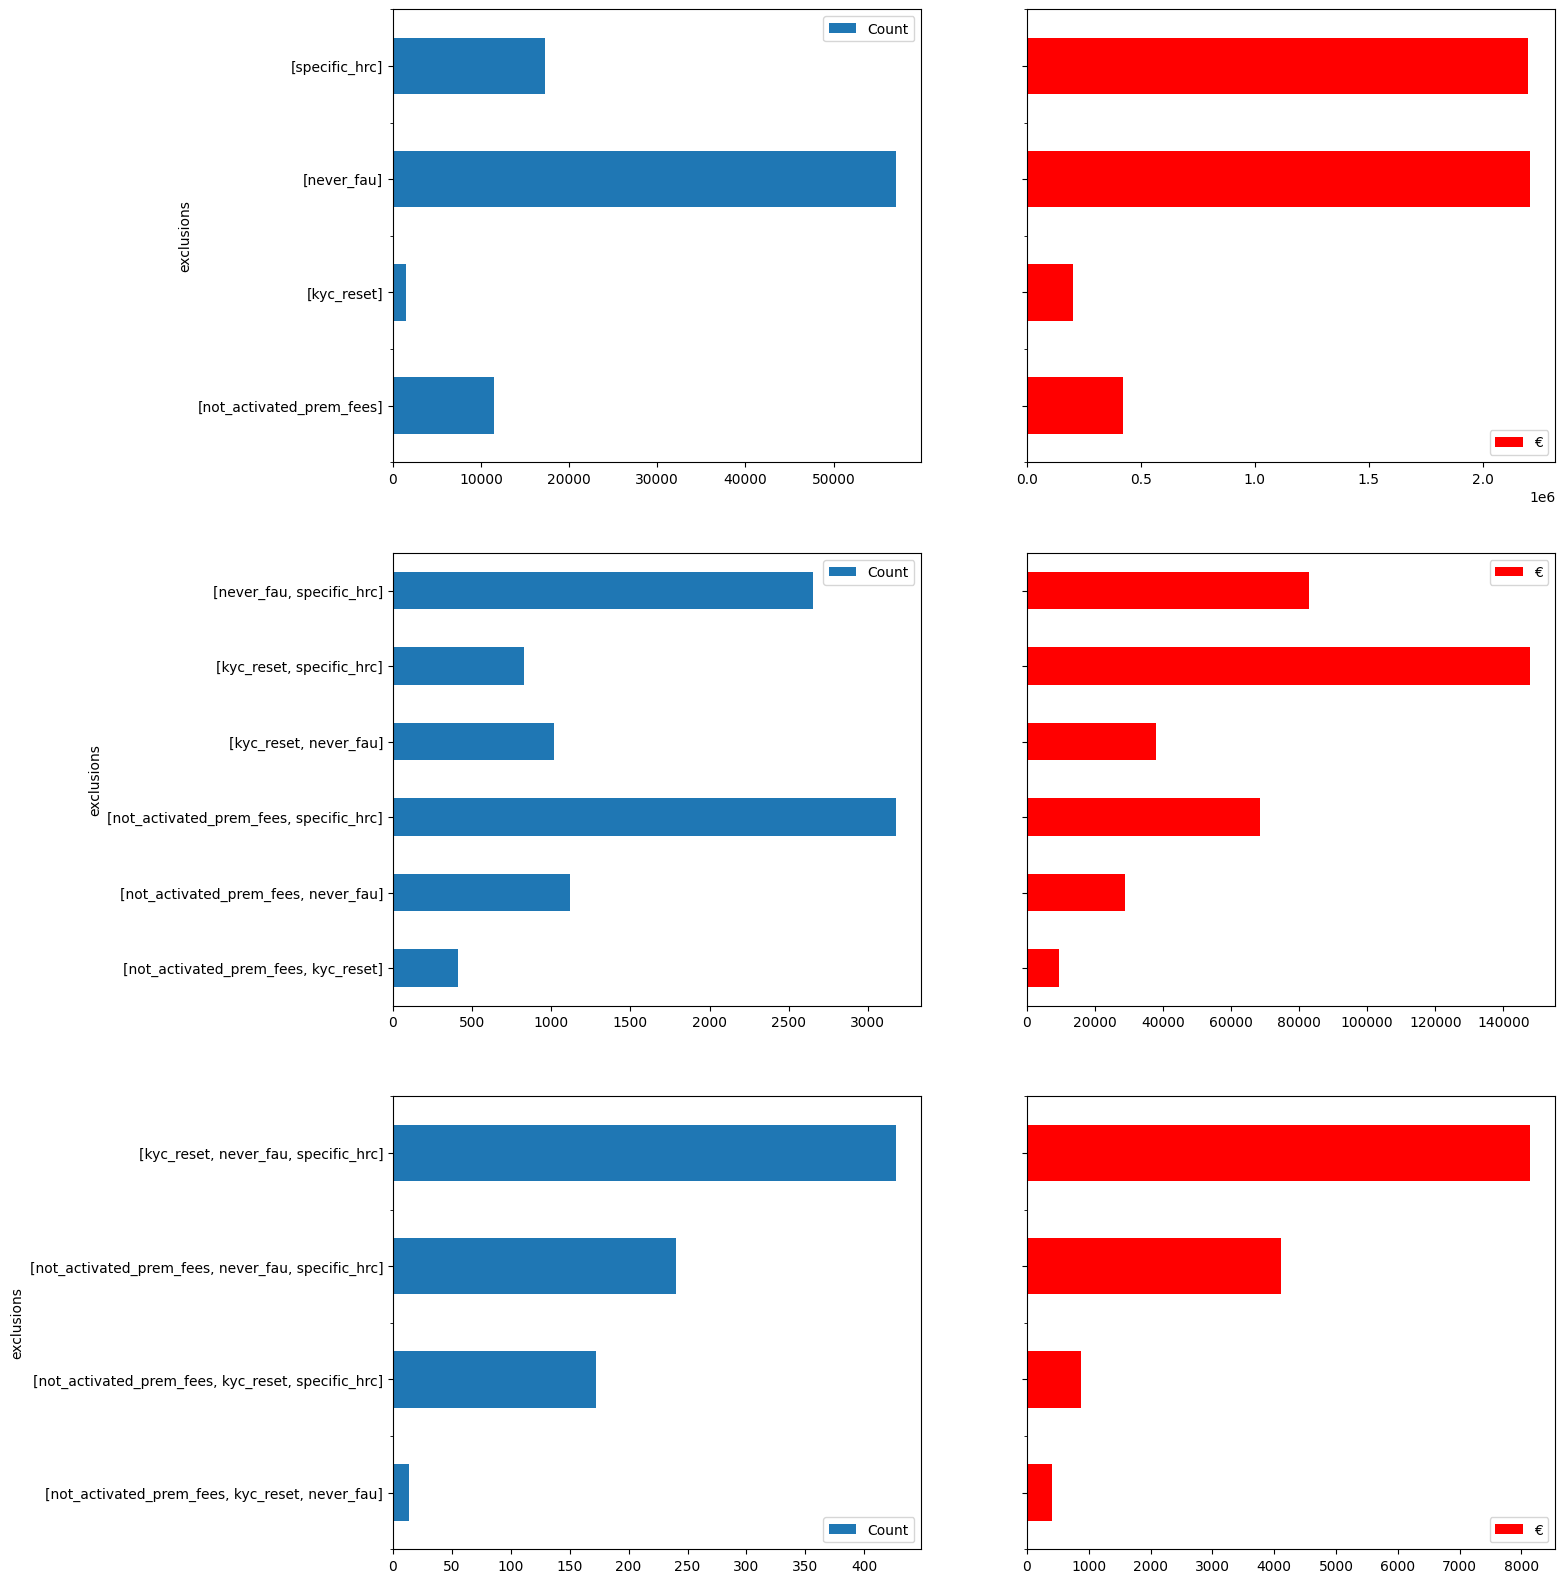

In [37]:
plot(result_2)

In [38]:
def calc_total_amt():
    exclusion = []
    tot_amt = []

    for k in list(result_2.exclusions):
        subsets = subsets_cardinality_n(len(k), k)
        last_element = subsets[-1]

        total_sum = 0

        # Iterate through list of all subsets of k.
        for excl in subsets:
            # we cannot easily compare to a list which is why we have to go the ugly route using indices.
            for i in range(len(result_2)):
                if result_2.exclusions.iloc[i] == excl:
                    total_sum += result_2.amt.iloc[i]

        # print('exclusions = ', k)
        # print('total_sum = ', total_sum)

        exclusion.append(k)
        tot_amt.append(total_sum)

        # print(len(exclusion), exclusion)
        # print(len(tot_amt), tot_amt)

    df = pd.DataFrame({"exclusions": exclusion, "amt": tot_amt})

    return df

In [39]:
total_amts = calc_total_amt()

In [40]:
total_amts["n_excl"] = total_amts.exclusions.apply(lambda x: len(x))

In [41]:
total_amt_plot = total_amts.sort_values(by=["n_excl", "amt"])

In [42]:
cm = {1: "green", 2: "blue", 3: "black"}


colors = list(total_amts.n_excl.map(cm))

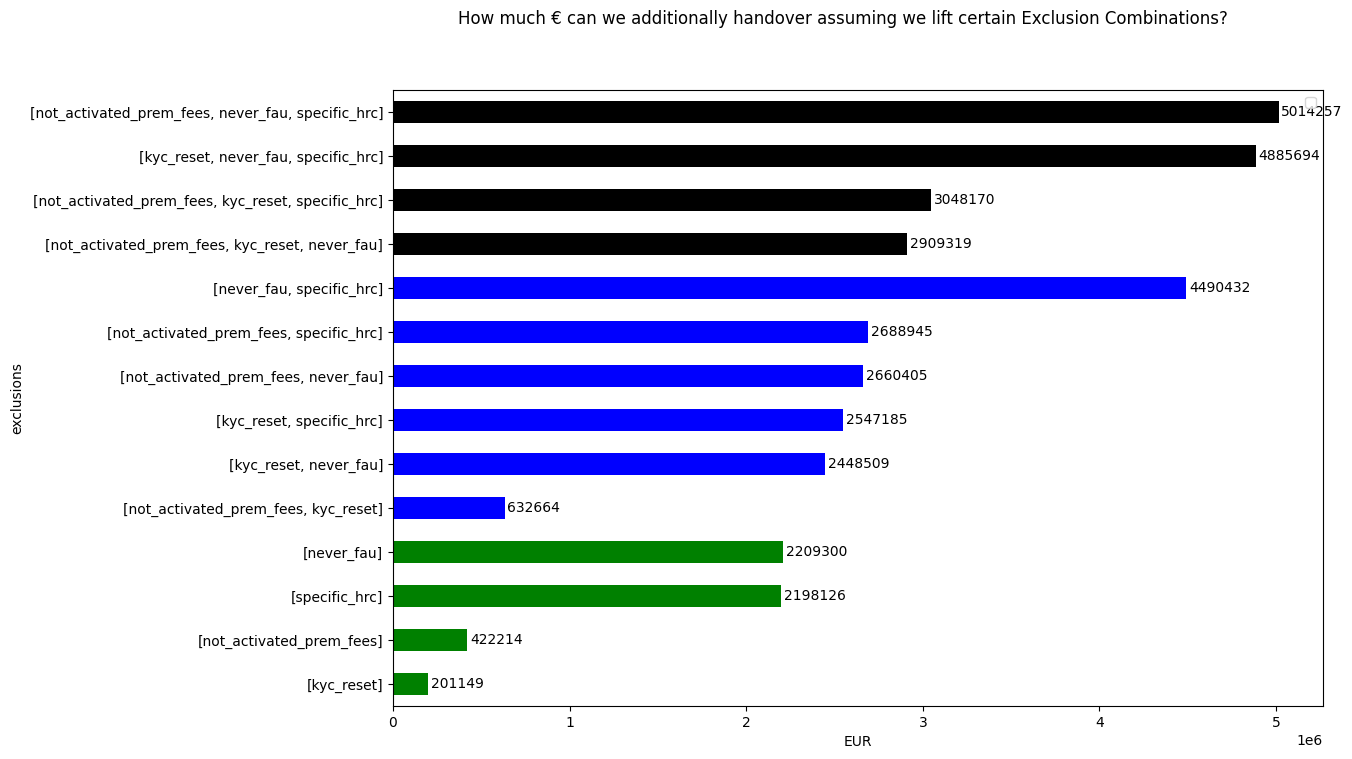

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

total_amt_plot.plot(kind="barh", x="exclusions", y="amt", color=colors, ax=ax)

for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", padding=2)

ax.legend(labels=())
ax.set_xlabel("EUR")

fig.suptitle(
    "How much € can we additionally handover assuming we lift certain Exclusion Combinations?"
)
plt.show()